# ML -> Supervisionado - Classificação

## Escolha de Features

- Usaremos o modelo RandomForest para escolher as features


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample

In [ ]:
DF_model = pd.read_parquet("../arquivos_parquet/DF_to_model.parquet")

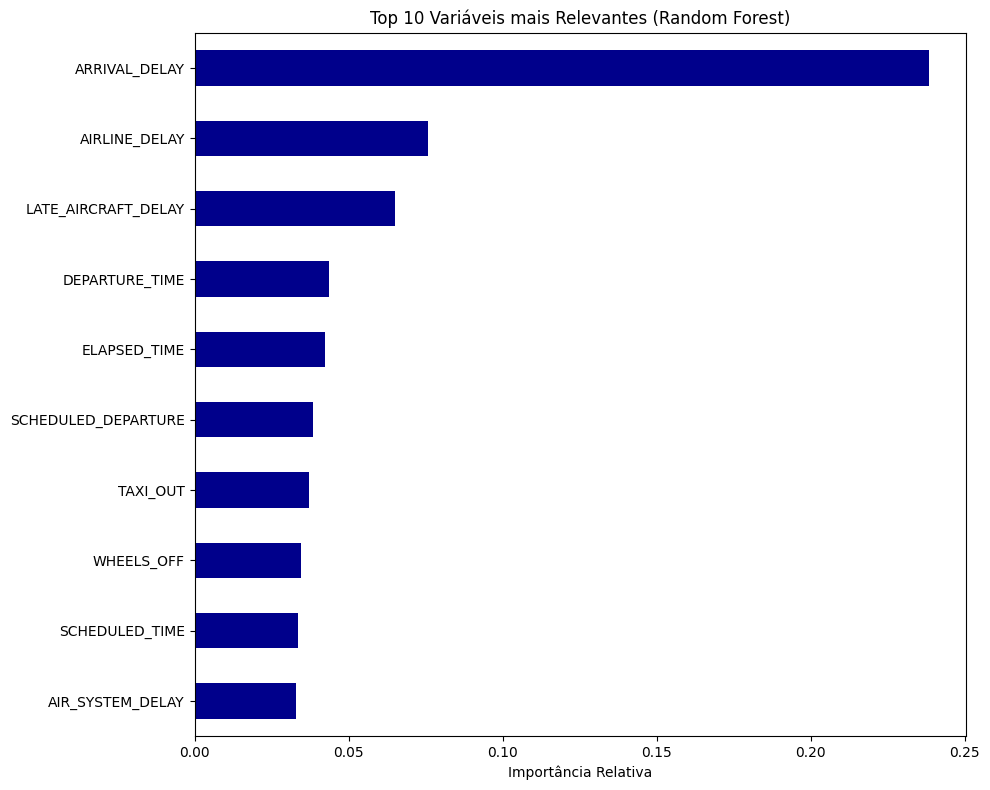

In [ ]:
target = "DELAY"

# Removendo DEPARTURE_DELAY para evitar vazamento (leakage), pois ele entrega a resposta
X = DF_model.drop(columns=[target, "DEPARTURE_DELAY"], errors="ignore")
y = DF_model[target]

# 1. Amostragem
X_sample = X.sample(n=1000000, random_state=42)
y_sample = y.loc[X_sample.index]

# 2. Encoding (Lógica mantida, com cópia explícita para evitar avisos do Pandas)
X_encoded = X_sample.copy()
for col in X_encoded.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

# 3. Treino do Random Forest
# n_jobs=-1 usa todos os núcleos do processador (essencial para 1 milhão de linhas)
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(X_encoded, y_sample)

# 4. Extração de Importâncias
importancias = pd.Series(rf.feature_importances_, index=X_encoded.columns)
importancias_top = importancias.sort_values(ascending=False).head(10)

# 5. Visualização
plt.figure(figsize=(10, 8))
importancias_top.plot(kind="barh", color="darkblue")
plt.title("Top 10 Variáveis mais Relevantes (Random Forest)")
plt.xlabel("Importância Relativa")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 6. Seleção final
features = importancias_top.index.tolist()
val_features = DF_model[features + [target]].copy()

In [12]:
val_features.head(10)

,ARRIVAL_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,DEPARTURE_TIME,ELAPSED_TIME,SCHEDULED_DEPARTURE,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,AIR_SYSTEM_DELAY,DELAY
0,-22.0,0.0,0.0,2354.0,194.0,5,21.0,15.0,205.0,0.0,0
1,-9.0,0.0,0.0,2.0,279.0,10,12.0,14.0,280.0,0.0,0
2,5.0,0.0,0.0,18.0,293.0,20,16.0,34.0,286.0,0.0,0
3,-9.0,0.0,0.0,15.0,281.0,20,15.0,30.0,285.0,0.0,0
4,-21.0,0.0,0.0,24.0,215.0,25,11.0,35.0,235.0,0.0,0
5,8.0,0.0,0.0,20.0,230.0,25,18.0,38.0,217.0,0.0,0
6,-17.0,0.0,0.0,19.0,170.0,25,11.0,30.0,181.0,0.0,0
7,-10.0,0.0,0.0,44.0,249.0,30,13.0,57.0,273.0,0.0,1
8,-13.0,0.0,0.0,19.0,193.0,30,17.0,36.0,195.0,0.0,0
9,-15.0,0.0,0.0,33.0,203.0,30,12.0,45.0,221.0,0.0,1


# Criando o Modelo


Relatório de Classificação - Naive Bayes (Base Original):
              precision    recall  f1-score   support

           0       0.74      0.99      0.85    976515
           1       0.96      0.43      0.60    590085

    accuracy                           0.78   1566600
   macro avg       0.85      0.71      0.72   1566600
weighted avg       0.83      0.78      0.75   1566600



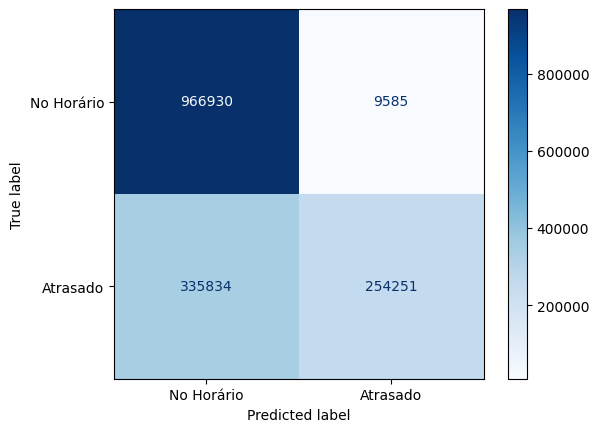

In [ ]:
# 1. Preparação dos dados
flights_feature = DF_model[features + ["DELAY"]].copy()
X = flights_feature[features].copy()
y = flights_feature["DELAY"]

# 2. Identificação automática (Sintaxe limpa)
colunas_categoricas = X.select_dtypes(
    include=["object", "category"]
).columns.tolist()
colunas_numericas = X.select_dtypes(include=["number"]).columns.tolist()

# 3. Definição do Pré-processador
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), colunas_numericas),
        (
            "cat",
            OrdinalEncoder(
                handle_unknown="use_encoded_value", unknown_value=-1
            ),
            colunas_categoricas,
        ),
    ]
)

# 4. Divisão Treino/Teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# 5. APLICAÇÃO CORRETA DO PROCESSAMENTO
# Usamos o preprocessor para tratar X_train e X_test de forma segura
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# 6. Treinamento do Modelo
modelo_nb = GaussianNB()
modelo_nb.fit(X_train_processed, y_train)

# 7. Predição e Relatório
y_pred = modelo_nb.predict(X_test_processed)

print("Relatório de Classificação - Naive Bayes (Base Original):")
print(classification_report(y_test, y_pred))

# Visualização da Matriz de Confusão para sua demonstração
ConfusionMatrixDisplay.from_estimator(
    modelo_nb,
    X_test_processed,
    y_test,
    display_labels=["No Horário", "Atrasado"],
    cmap="Blues",
    values_format="d",
)

#### Diagnóstico do Baseline (Naive Bayes)

- O modelo atual está sofrendo de um viés severo em direção à classe majoritária (No Horário).<br>
  Embora a acurácia geral seja de 78%, esse número é enganoso para o nosso problema de negócio.
  - **O Problema do Recall (Sensibilidade):** Identificamos apenas 43% dos atrasos. <br>
    Em um cenário logístico ou operacional, isso significa que mais da metade dos problemas reais <br>
    passariam "no radar" do sistema sem nenhum alerta.
  - **A "Aposta Segura" do Modelo:** A precisão de 96% para a classe "Atrasado" nos mostra <br>
    que o Naive Bayes só classifica algo como atraso quando as evidências são esmagadoras.<br>
    Ele está sendo conservador demais para evitar falsos positivos, o que resulta em um <br>
    volume inaceitável de 335.834 Falsos Negativos.
  - **Desequilíbrio de Classe:** Temos quase o dobro de exemplos de "No Horário" em relação a "Atrasado".<br>
    O modelo aprendeu que, na dúvida, prever "No Horário" garante uma acurácia alta.


# Equilibrando as Bases


Relatório Naive Bayes - Com Upsampling (Sem Leakage):
              precision    recall  f1-score   support

           0       0.74      0.99      0.85    976515
           1       0.96      0.43      0.60    590085

    accuracy                           0.78   1566600
   macro avg       0.85      0.71      0.72   1566600
weighted avg       0.83      0.78      0.75   1566600



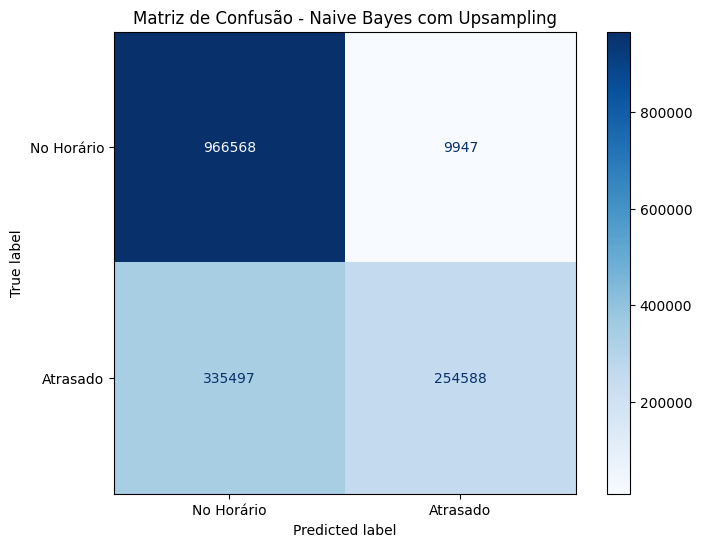

In [18]:
# 1. Divisão ANTES do equilíbrio (Fundamental para evitar leakage)
X_train_raw, X_test, y_train_raw, y_test = train_test_split(
    flights_feature[features],
    flights_feature["DELAY"],
    test_size=0.3,
    random_state=42,
)

# 2. Rebalanceamento APENAS do Treino
df_train = pd.concat([X_train_raw, y_train_raw], axis=1)
df_majoritario = df_train[df_train.DELAY == 0]
df_minoritario = df_train[df_train.DELAY == 1]

df_minoritario_upsampled = resample(
    df_minoritario, replace=True, n_samples=len(df_majoritario), random_state=7
)

df_train_equilibrado = pd.concat([df_majoritario, df_minoritario_upsampled])
X_train = df_train_equilibrado[features]
y_train = df_train_equilibrado["DELAY"]

# 3. Processamento Automático (Usando o preprocessor que evita erros de tipo)
preprocessor = ColumnTransformer(
    transformers=[
        (
            "num",
            StandardScaler(),
            X_train.select_dtypes(include=["number"]).columns.tolist(),
        ),
        (
            "cat",
            OrdinalEncoder(
                handle_unknown="use_encoded_value", unknown_value=-1
            ),
            X_train.select_dtypes(
                include=["object", "category"]
            ).columns.tolist(),
        ),
    ]
)

# 4. Fit e Transform
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# 5. Modelo e Avaliação
modelo_nb = GaussianNB()
modelo_nb.fit(X_train_processed, y_train)

y_pred = modelo_nb.predict(X_test_processed)
print("Relatório Naive Bayes - Com Upsampling (Sem Leakage):")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

# 6. Matriz de Confusão
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["No Horário", "Atrasado"]
)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap="Blues", values_format="d", ax=ax)
plt.title("Matriz de Confusão - Naive Bayes com Upsampling")
plt.grid(False)  # Garante que as linhas do grid não fiquem sobre os números
plt.show()

- Rodamos o Naive Bayes com Upsampling na classe minoritária (Atrasados) e, curiosamente, <br>
  os números praticamente não se moveram. Isso nos traz insights valiosos sobre a natureza <br>
  dos dados e as limitações do algoritmo atual.


#### 1. Diagnóstico da Estagnação (Upsampling)

- **Recall Imutável:** O Recall para a classe "Atrasado" permaneceu em 0.43. <br>
  Isso indica que o Naive Bayes atingiu o seu "teto de aprendizado". <br>
  Mesmo vendo mais exemplos de atraso, ele não consegue encontrar padrões <br>
  que os diferenciem melhor dos casos "No Horário".

- **Falsos Negativos Persistentes:** Ainda temos 335.497 erros onde <br>
  o modelo não previu o atraso. Isso prova que o problema não é apenas <br>
  a quantidade de dados (volume), mas a capacidade de separação linear do algoritmo.

- **Acurácia e F1-Score Estáveis:** As métricas de 0.78 (Acurácia) e <br>
  0.60 (F1 para classe 1) mostram que o upsampling, neste caso específico <br>
  do Naive Bayes, não foi o "remédio" esperado.

####


#### 2. O Insight Técnico: Por que não funcionou?

- O Naive Bayes é um classificador probabilístico que assume que as variáveis<br>
  são independentes. Quando o Upsampling não surte efeito, <br>
  isso geralmente aponta para dois cenários:
  _ **Sobreposição de Classes:** As características de um voo/viagem atrasada <br>
  são numericamente muito parecidas com as de uma no horário. <br>
  O Naive Bayes não consegue traçar uma "fronteira" clara entre elas.
  _ **Simplicidade do Modelo:** O modelo não consegue aprender interações <br>
  (ex: "Se o clima é X E a rota é Y, então atrasa"). <br>
  Ele olha para cada fator isoladamente.


# Testando o Modelo XGBOOST


Treinamento concluído na iteração: 499

Relatório de Classificação - XGBoost (Base Equilibrada):
              precision    recall  f1-score   support

           0       0.89      0.92      0.90    976515
           1       0.85      0.82      0.84    590085

    accuracy                           0.88   1566600
   macro avg       0.87      0.87      0.87   1566600
weighted avg       0.88      0.88      0.88   1566600



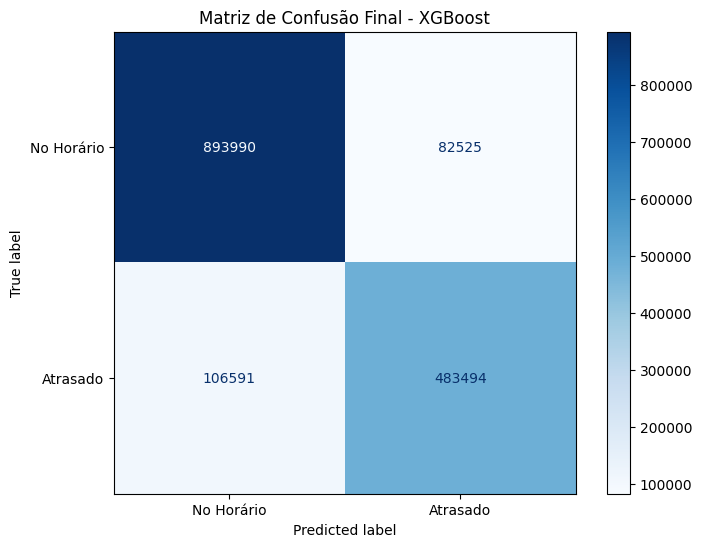

In [ ]:
# 1. Definição do Modelo com os hiperparâmetros escolhidos
modelo_xgb = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=7,
    subsample=0.7,
    colsample_bytree=0.8,
    min_child_weight=5,
    gamma=1,
    reg_alpha=1.0,
    reg_lambda=1.0,
    random_state=42,
    early_stopping_rounds=10,
    eval_metric="logloss",
)

# 2. Treinamento
modelo_xgb.fit(
    X_train_processed,
    y_train,
    eval_set=[(X_test_processed, y_test)],
    verbose=False,
)

# 3. Previsões usando a melhor iteração encontrada pelo early stopping
y_pred_xgb = modelo_xgb.predict(X_test_processed)

# 4. Exibição dos Resultados
print(f"Treinamento concluído na iteração: {modelo_xgb.best_iteration}")
print("\nRelatório de Classificação - XGBoost (Base Equilibrada):")
print(classification_report(y_test, y_pred_xgb))

# 5. Matriz de Confusão com Valores Completos
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["No Horário", "Atrasado"]
)

# Plotagem com o formato de dígito inteiro 'd'
disp.plot(cmap="Blues", values_format="d", ax=ax)

plt.title("Matriz de Confusão Final - XGBoost")
plt.grid(False)  # Garante que as linhas de grade não fiquem sobre os números
plt.show()

Dicionário de Features:
f0 -> ARRIVAL_DELAY
f1 -> AIRLINE_DELAY
f2 -> LATE_AIRCRAFT_DELAY
f3 -> DEPARTURE_TIME
f4 -> ELAPSED_TIME
f5 -> SCHEDULED_DEPARTURE
f6 -> TAXI_OUT
f7 -> WHEELS_OFF
f8 -> SCHEDULED_TIME
f9 -> AIR_SYSTEM_DELAY


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

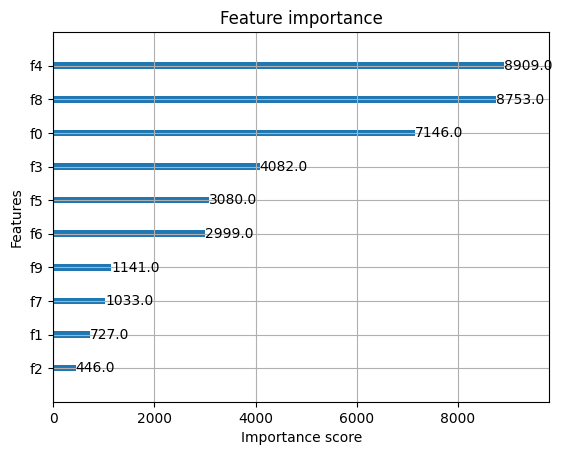

In [ ]:
# Mapeia a posição (f + índice) para o nome real da feature
mapeamento_features = {f"f{i}": col for i, col in enumerate(features)}

print("Dicionário de Features:")
for f_code, nome_real in mapeamento_features.items():
    print(f"{f_code} -> {nome_real}")

xgb.plot_importance(modelo_xgb)

#### 1. Diagnóstico do XGBoost (O Salto de Performance)

- Diferente do Naive Bayes, o XGBoost conseguiu "aprender" a complexidade do problema.<br>
  Os números mostram uma evolução drástica na capacidade preditiva:

  - **Recall de Atrasados (Classe 1):** Saltamos de estagnados 0.43 para robustos 0.82.<br>
    Isso significa que agora capturamos a grande maioria dos atrasos reais.
  - **Equilíbrio de Precisão:** Mantivemos uma precisão sólida de 0.85.<br>
    O modelo não está apenas "chutando" que tudo vai atrasar; <br>
    ele está identificando padrões reais.
  - **Falsos Negativos:** Reduzimos os erros críticos de ~335 mil para apenas 106.591.<br>
    É uma redução de mais de 65% no erro que mais custa para a operação.

#### 2.Conclusão sobre os Modelos e suas Limitações

- **Naive Bayes (Base Original)**

  - Conservador e enviesado pela classe majoritária.
  - Incapacidade de lidar com desequilíbrio e correlação entre variáveis.

- **Naive Bayes (Upsampling)**

  - Praticamente nulo. O "volume" extra de dados não compensou a fraqueza teórica do algoritmo.
  - Prova que o problema não era falta de dados, mas sim a simplicidade do modelo.

- **XGBoost (Equilibrado)**
  - Alta capacidade de generalização e captura de relações não-lineares.
  - Maior custo computacional e necessidade de ajuste fino de hiperparâmetros (tuning).

#### 3. Insights Finais

- **Complexidade é necessária:** Para problemas logísticos/comportamentais (como atrasos), <br>
  algoritmos lineares ou probabilísticos simples raramente bastam. <br>
  A interação entre "horário", "dia da semana" e "clima" exige modelos de Boosting.

- **Dados vs. Algoritmo:** O experimento com Upsampling no Naive Bayes foi o mais valioso,<br>
  pois confirmou que mais dados não salvam um modelo inadequado.

- **Pronto para Produção:** O modelo XGBoost apresenta o melhor balanço <br>
  entre o risco de perder um atraso (Recall) e o risco de dar um alarme falso (Precision).
